# CPSC 392 Final Project: Spotify Tracks from 1922-2021 
*Spring 2021 CPSC 392-04*

## Spotify Data from Kaggle
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

## Motivation for Project
I've been looking to work with data from Spotify, and I came across these sets from Kaggle, with artist and track information. I decided to merge them by artist to have more insight into the tracks.
Then, I came up with questions to investigate this Spotify track information:

- By what characteristics can we group/cluster tracks?

- How can we predict the popularity of a track and what are the most important predictors?

- Does the popularity of an artist change if they release a variety of track styles?

- What subcategories of tracks exist?

- For individual artists, what leads to differences in popularity for their tracks?

- Do different genres see varying levels of popularity, and does this change over time?

- How can we visualize the differences between genres of the tracks?

I chose to investigate 3 out of the 6 questions I originally posed:

1. **How can we predict the popularity of a track and what are the most important predictors?**

2. **Do different genres see varying levels of popularity, and does this change over time?**

3. **By what characteristics can we group/cluster tracks? What subcategories of tracks exist?**

### Load packages

In [226]:
import warnings
warnings.filterwarnings('ignore')

from plotnine import *
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split # simple TT split cv

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from siuba.dply.forcats import fct_lump, fct_reorder 

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn.metrics import silhouette_score

np.random.seed = 2000

### Load data

In [227]:
filepath = '/users/Corinne/Documents/CPSC 392/'

tracks = pd.read_csv(filepath + "tracks.csv")
artists = pd.read_csv(filepath + "artists.csv")

### Data Cleaning

In [228]:
new_id = []
for x in artists.id:
    x_correct = "['" + x + "']"
    new_id.append(x_correct)


In [229]:
artists['id'] = new_id

In [230]:
artists.dropna()

,id,followers,genres,name,popularity
0,['0DheY5irMjBUeLybbCUEZ2'],0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,['0DlhY15l3wsrnlfGio2bjU'],5.0,[],ปูนา ภาวิณี,0
2,['0DmRESX2JknGPQyO15yxg7'],0.0,[],Sadaa,0
3,['0DmhnbHjm1qw6NCYPeZNgJ'],0.0,[],Tra'gruda,0
4,['0Dn11fWM7vHQ3rinvWEl4E'],2.0,[],Ioannis Panoutsopoulos,0
...,...,...,...,...,...
1104344,['6rJIG42vcWAf1UBdRFlQxB'],3345.0,[],Cody Longo,8
1104345,['1ljurfXKPlGncNdW3J8zJ8'],2123.0,['deep acoustic pop'],Right the Stars,18
1104346,['2vnT9YhKIvjVo9LnVjWmr2'],26.0,[],Jesse Giddings,0
1104347,['3ID0E5XCvnJIYZEq043ZoB'],406.0,[],The Boy Band Project,0


#### Merge data frames

In [231]:
full_DF = pd.merge(tracks, artists, left_on = "id_artists", right_on = "id", how = "inner")
#full_DF.info

#### Create a dataframe of only the entries with genre information

In [232]:
genres = full_DF["genres"] != "[]"

spotify = full_DF.loc[genres]

In [233]:
#spotify

In [234]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432162 entries, 56 to 469582
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id_x              432162 non-null  object 
 1   name_x            432162 non-null  object 
 2   popularity_x      432162 non-null  int64  
 3   duration_ms       432162 non-null  int64  
 4   explicit          432162 non-null  int64  
 5   artists           432162 non-null  object 
 6   id_artists        432162 non-null  object 
 7   release_date      432162 non-null  object 
 8   danceability      432162 non-null  float64
 9   energy            432162 non-null  float64
 10  key               432162 non-null  int64  
 11  loudness          432162 non-null  float64
 12  mode              432162 non-null  int64  
 13  speechiness       432162 non-null  float64
 14  acousticness      432162 non-null  float64
 15  instrumentalness  432162 non-null  float64
 16  liveness          4

#### Rename columns appropriately

In [235]:

spotify["track_id"] = spotify["id_x"]
spotify["track"] = spotify["name_x"]
spotify["track_popularity"] = spotify['popularity_x']
spotify["artist"] = spotify['name_y']
spotify['artist_popularity'] = spotify['popularity_y']

#spotify.head()

In [236]:
spotify = spotify.drop(["id_y", "id_x", 'name_x', 'popularity_x', 'name_y', 'popularity_y'], 1)

#### Mutate release date to year

In [237]:
spotify['release_date'][56]

release_year = []
for x in spotify['release_date']:
    year = int(x[0:4])
    release_year.append(year)

In [238]:
spotify['release_year'] = release_year

In [239]:
#spotify.head()

In [240]:
spotify = spotify.rename(columns = {"followers" : "artist_followers"})

In [241]:
max(spotify.artist_popularity)

100

#### Turn key from numerical note representation back to letter representation

In [242]:
key = []
for x in spotify.key:
    if x == 0:
        key.append("C")
    elif x == 1:
        key.append('C#/Db')
    elif x == 2:
        key.append('D')
    elif x == 3:
        key.append('D#/Eb')
    elif x == 4:
        key.append('E')
    elif x == 5:
        key.append('F')
    elif x == 6:
        key.append('F#/Gb')
    elif x == 7:
        key.append('G')
    elif x == 8:
        key.append('G#/Ab')
    elif x == 9:
        key.append('A')
    elif x == 10:
        key.append('A#/Bb')
    elif x == 11:
        key.append('B')
spotify['key'] = key


#### Get dummy variables for keys

In [243]:
dummies = pd.get_dummies(spotify["key"])

spotify = pd.concat([spotify,dummies], axis = 1)

#### Avoid time signatures of 0

In [244]:
nonzeros = spotify["time_signature"] != 0
spotify = spotify.loc[nonzeros]

#### Create a main genre variable and from that create dummy variables for common genres

In [245]:
genre = []
for x in spotify.genres:
    split = x.split(",", 1)
    genre1 = split[0]
    genre1 = genre1.replace('[', '')
    if ']' in genre1:
        genre1 = genre1.replace(']', '')
    genre.append(genre1)
#len(genre)

In [246]:
classical_genres = ["symphony", "choral", "opera", "quartet", "quintet", "trio",
                   "concerto", "classical", "operatic", "aria"]
classical = []
for name in genre:
    yes = 0
    for word in classical_genres:
        if word in name:
            yes = 1
            classical.append(yes)
            break
    if yes == 0:
        classical.append(yes)
#len(classical)       

In [247]:
spotify['classical'] = classical
spotify['main_genre'] = genre

In [248]:
pop = []
for name in genre:
    if "pop" in name:
        pop.append(1)
    else:
        pop.append(0)
#print(len(pop))       


In [249]:
rock = []
for name in genre:
    if "rock" in name:
        rock.append(1)
    else:
        rock.append(0)
#print(len(rock))       


In [250]:
rap = []
for name in genre:
    if "rap" in name:
        rap.append(1)
    elif "trap" in name:
        rap.append(1)
    else:
        rap.append(0)


In [251]:
country = []
for name in genre:
    if "country" in name:
        country.append(1)
    else:
        country.append(0)
#print(len(country), sum(country))       


In [252]:
alt = []
for name in genre:
    if "alternative" in name:
        alt.append(1)
    elif "alt" in name:
        alt.append(1)
    else:
        alt.append(0)
#print(len(alt), sum(alt))       


In [253]:
punk = []
for name in genre:
    if "punk" in name:
        punk.append(1)
    else:
        punk.append(0)
#print(len(punk), sum(punk))       


In [254]:
jazz = []
for name in genre:
    if "jazz" in name:
        jazz.append(1)
    elif "blues" in name:
        jazz.append(1)
    else:
        jazz.append(0)
#print(len(jazz), sum(jazz))       


In [255]:
indie = []
for name in genre:
    if "indie" in name:
        indie.append(1)
    else:
        indie.append(0)
#print(len(indie), sum(indie))       


In [256]:
spotify['classical'] = classical
spotify['main_genre'] = genre
spotify['pop'] = pop
spotify['rock'] = rock
spotify['rap'] = rap
spotify['country'] = country
spotify['alternative'] = alt
spotify['punk'] = punk
spotify['jazz'] = jazz
spotify['indie'] = indie

In [257]:
dummies1 = pd.get_dummies(spotify["time_signature"])
spotify = pd.concat([spotify, dummies1], axis = 1)
spotify = spotify.rename(columns = { 1 : "1", 3 : '3', 4 : '4', 5 : '5'})

In [258]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432000 entries, 56 to 469582
Data columns (total 51 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   duration_ms        432000 non-null  int64  
 1   explicit           432000 non-null  int64  
 2   artists            432000 non-null  object 
 3   id_artists         432000 non-null  object 
 4   release_date       432000 non-null  object 
 5   danceability       432000 non-null  float64
 6   energy             432000 non-null  float64
 7   key                432000 non-null  object 
 8   loudness           432000 non-null  float64
 9   mode               432000 non-null  int64  
 10  speechiness        432000 non-null  float64
 11  acousticness       432000 non-null  float64
 12  instrumentalness   432000 non-null  float64
 13  liveness           432000 non-null  float64
 14  valence            432000 non-null  float64
 15  tempo              432000 non-null  float64
 16  t

## Question #2: How can we predict the popularity of a track and what are the most important predictors?

### Regularization with linear regression

In [259]:
spotify.columns

Index(['duration_ms', 'explicit', 'artists', 'id_artists', 'release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'artist_followers', 'genres', 'track_id', 'track',
       'track_popularity', 'artist', 'artist_popularity', 'release_year', 'A',
       'A#/Bb', 'B', 'C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G',
       'G#/Ab', 'classical', 'main_genre', 'pop', 'rock', 'rap', 'country',
       'alternative', 'punk', 'jazz', 'indie', '1', '3', '4', '5'],
      dtype='object')

#### Set up predictors and outcome variable

In [260]:
#Did not include the base levels to compare the dummies - no key of C or time signature of 4. 
#Using "other" for genres as point of comparison

y = spotify['track_popularity']
predictors =['duration_ms', 'explicit', 'release_year', 
'danceability', 'energy','loudness', 'mode', 'speechiness', 'acousticness',
 'instrumentalness', 'liveness', 'valence', 'tempo',
'artist_followers', 'artist_popularity', 'A', 'A#/Bb', 'B', 'C#/Db', 'D', 
'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'classical','pop','rock',               
'rap','country','alternative','punk','jazz','indie', '1', '3', '5']
x = spotify[predictors]
#x

#### Standardize the numeric features for the training and testing sets

In [261]:
features = ['duration_ms', 'danceability', 'energy', 'loudness',
'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
'artist_followers', 'artist_popularity', 'release_year']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25)

z = StandardScaler()

x_train[features] = z.fit_transform(x_train[features])
x_test[features] = z.transform(x_test[features])

#x_train

#### Create Lasso and Ridge models and compare r-squared and mean-squared error values between train and test sets

In [262]:
lr_lasso = Lasso()
lr_lasso.fit(x_train, y_train)

print("\nLASSO Train R2: ", r2_score(y_train, lr_lasso.predict(x_train)))
print("LASSO Test R2: ", r2_score(y_test, lr_lasso.predict(x_test)))
print("LASSO Train MSE: ", mean_squared_error(y_train, lr_lasso.predict(x_train)))
print("LASSO Test MSE: ", mean_squared_error(y_test, lr_lasso.predict(x_test)))


lr_ridge = Ridge()
lr_ridge.fit(x_train, y_train)

print("\nRidge Train R2: ", r2_score(y_train, lr_ridge.predict(x_train)))
print("Ridge Test R2: ", r2_score(y_test, lr_ridge.predict(x_test)))
print("Ridge Train MSE: ", mean_squared_error(y_train, lr_ridge.predict(x_train)))
print("Ridge Test MSE: ", mean_squared_error(y_test, lr_ridge.predict(x_test)))


LASSO Train R2:  0.47786007066243763
LASSO Test R2:  0.47999249340853367
LASSO Train MSE:  152.55953201110592
LASSO Test MSE:  151.88645491213214

Ridge Train R2:  0.5072738108890189
Ridge Test R2:  0.5100640541699535
Ridge Train MSE:  143.96538666513214
Ridge Test MSE:  143.10299948152587


#### Create data frames of coefficients and plot coefficients for LASSO and Ridge regressions

In [263]:
ridge_df = pd.DataFrame({'Coefs': lr_ridge.coef_, "Variables": predictors})

In [264]:
ridge_coef_plot1 = (ggplot(ridge_df[0:5], aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity", width = 0.8) + ylab("Coefficient Value") + ggtitle("Ridge Track Characteristic Coefficients") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 8, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))

ridge_coef_plot2 = (ggplot(ridge_df[5:10], aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity", width = 0.8) + ylab("Coefficient Value") + ggtitle("Ridge Track Characteristic Coefficients") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 8, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))

ridge_coef_plot3 = (ggplot(ridge_df[10:15], aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity", width = 0.8) + ylab("Coefficient Value") + ggtitle("Ridge Track Characteristic Coefficients") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 8, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))

In [265]:
key_plot1 = (ggplot(ridge_df[15:26], aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity", width = 0.8) + ylab("Coefficient Value") + ggtitle("Ridge Coefficients for Key Compared to C") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 9, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))



In [266]:
genre_plot = (ggplot(ridge_df[26:35], aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity", width = 0.8) + ylab("Coefficient Value") + ggtitle("Ridge Coefficients for Genre") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 8, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))


In [267]:
time_plot = (ggplot(ridge_df[35:38], aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity", width = 0.8) + ylab("Coefficient Value") + ggtitle("Ridge Coefficients for Time Signature Compared to 4/4") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 8, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))


In [268]:
lasso_df = pd.DataFrame({'Coefs': lr_lasso.coef_, "Variables": predictors})

In [269]:
idx = [2,5,8,10,14]
sig_coefs = lasso_df.iloc[idx]
lasso_coef_plot = (ggplot(sig_coefs, aes(x = "Variables", y = "Coefs", fill = "Variables")) +
geom_bar(stat = "identity") + ylab("Coefficient Value") + ggtitle("LASSO Predictor Coefficient Values") +
theme_minimal() +
theme(panel_grid_major_x = element_blank(),
     panel_grid_minor_x = element_blank(),
     legend_position = "none",
     axis_title_x = element_blank(),
     axis_title_y = element_text(size = 12),
     axis_text_x = element_text(size = 9, color = "black"),
     axis_text_y = element_text(size = 9, color = "black")))

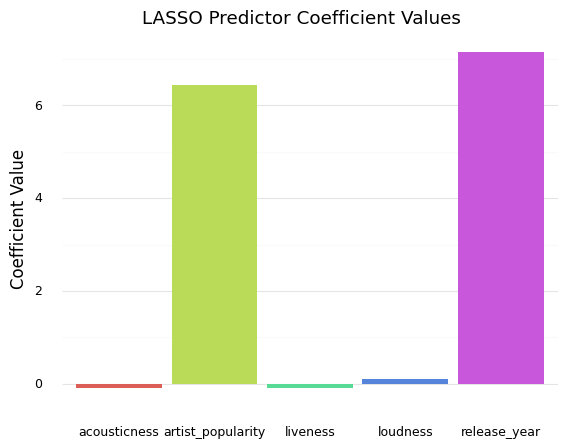

<ggplot: (109122340063)>

This bar graph shows the coefficients that LASSO did not shrink to 0. 
Here we see that release_year and artist_popularity are the largest coefficients,
implying that they have the largest impact on a track's popularity.


In [270]:
print(lasso_coef_plot)
print("\nThis bar graph shows the coefficients that LASSO did not shrink to 0.",
      "\nHere we see that release_year and artist_popularity are the largest coefficients,")
print("implying that they have the largest impact on a track's popularity.")

The following bar plots contain the coefficients for the Ridge regression.


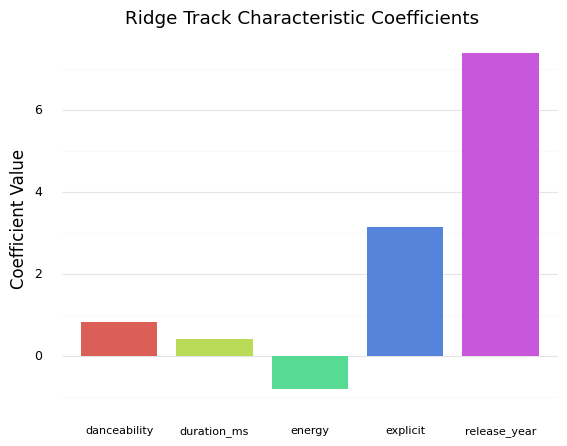

<ggplot: (109134253174)> 

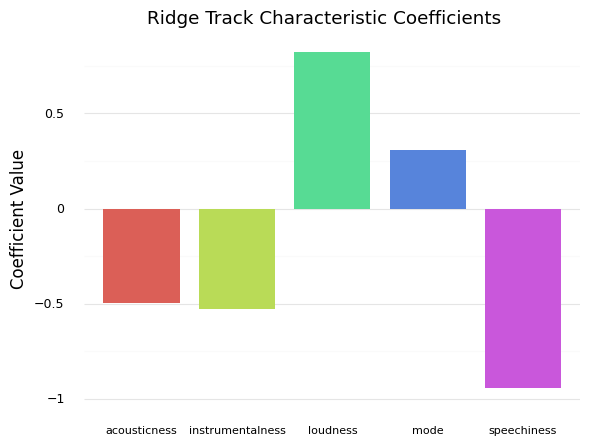

<ggplot: (109134253078)> 

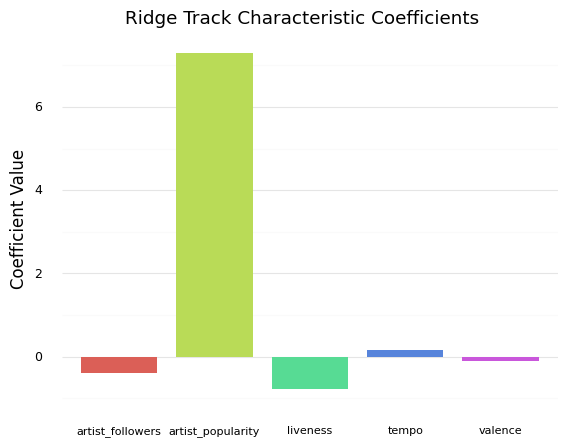

<ggplot: (109138871381)> 

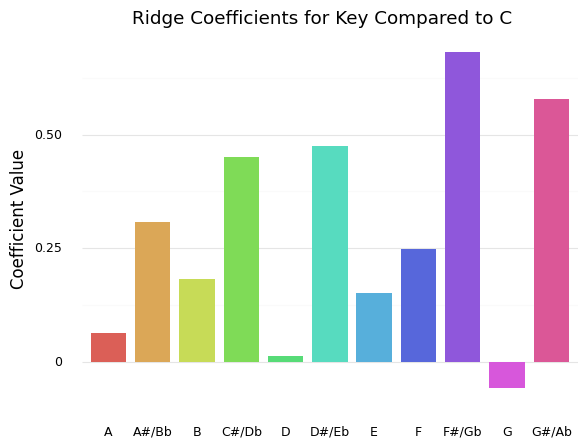

<ggplot: (109134242359)> 

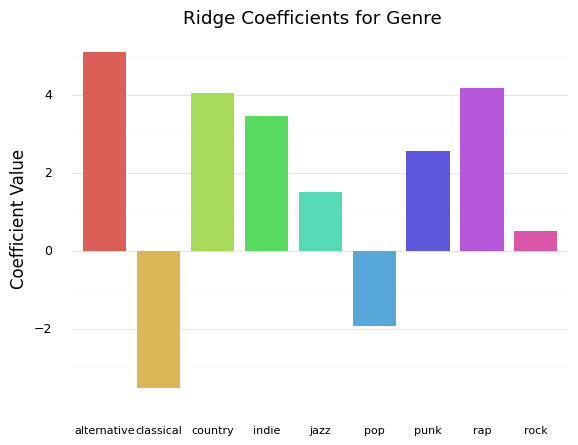

<ggplot: (109122174335)> 

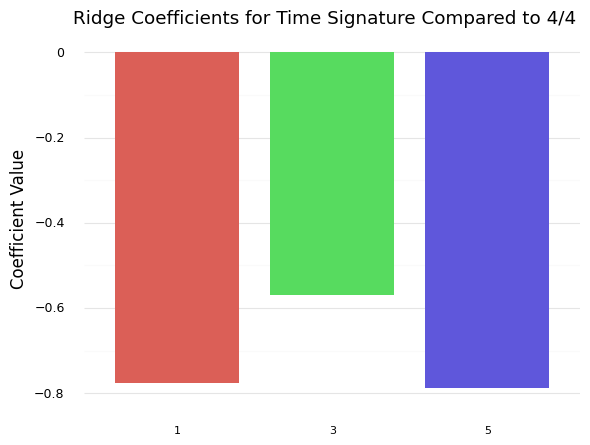

<ggplot: (109138871528)>


In [271]:
print("The following bar plots contain the coefficients for the Ridge regression.")
print(ridge_coef_plot1, ridge_coef_plot2, ridge_coef_plot3, key_plot1, genre_plot, time_plot)

#### Reprint training and testing R2 and MSE for easy comparison with analysis

In [272]:
print("NOTE: I added Ridge regression to experiment for the best regularization technique.")
print("\nLASSO Train R2: ", r2_score(y_train, lr_lasso.predict(x_train)))
print("LASSO Test R2: ", r2_score(y_test, lr_lasso.predict(x_test)))
print("LASSO Train MSE: ", mean_squared_error(y_train, lr_lasso.predict(x_train)))
print("LASSO Test MSE: ", mean_squared_error(y_test, lr_lasso.predict(x_test)))

print("\nRidge Train R2: ", r2_score(y_train, lr_ridge.predict(x_train)))
print("Ridge Test R2: ", r2_score(y_test, lr_ridge.predict(x_test)))
print("Ridge Train MSE: ", mean_squared_error(y_train, lr_ridge.predict(x_train)))
print("Ridge Test MSE: ", mean_squared_error(y_test, lr_ridge.predict(x_test)))

NOTE: I added Ridge regression to experiment for the best regularization technique.

LASSO Train R2:  0.47786007066243763
LASSO Test R2:  0.47999249340853367
LASSO Train MSE:  152.55953201110592
LASSO Test MSE:  151.88645491213214

Ridge Train R2:  0.5072738108890189
Ridge Test R2:  0.5100640541699535
Ridge Train MSE:  143.96538666513214
Ridge Test MSE:  143.10299948152587


## Question #2 Analysis
### How can we predict the popularity of a track and what are the most important predictors?

For this question, I performed Linear Regression with two different types of regularization: LASSO and Ridge. I used both because they handle coefficients differently. An ideal predictive model performs well on training data and testing data, or data it has already seen and new data. Regularization helps minimize the impact of variables on the model when the variables may be less significant in the overall population of the data. Minimizing this impact lowers the risk of overfitting, or biasing the model to the point where it performs poorly on new data. LASSO regularization shrinks less important variables to have a coefficient of zero, so that they will not impact the model. Ridge regularization penalizes the coefficients but does not eliminate them, so there are coefficients that just have a lesser impact on the model. 

The results of this model can be explained through the r-squared and mean-squared error values shown. The LASSO model's training r-squared was 0.4779, and increased to 0.4800 with the test data. The Ridge model had a higher training r-squared of 0.5073, which increased with the testing set to 0.5101. Both models' r-squared values imply that the variables used for the linear model explain around 50% of the variation in song popularity. The r-squared values increased from the training to test sets in both models, which implies that the model is actually underfit, or doesn't understand the patterns in the existing data and handles new data better because it's just guessing. Both test mean squared errors decreased from the training to the test set in both LASSO and Ridge regressions, which supports a diagnosis of underfit. This underfitting implies that a simple linear model cannot well predict track popularity.

It is worth noting that the most important variables for the regression, those with the largest magnitudes, are the artist's popularity and the song's release date. Spotify is a relatively new streaming service started within the last 15 years. As its consumer base has grown, it makes sense that music produced and listened to today would be more popular than music from a long time ago. The artist's popularity also is significant because they're usually well-known, which means they likely have the money to advertise their song and make it popular because they are popular. Interestingly, liveness and acousticness have negative impacts on whether the song will be popular. The negative liveness impact may be due to the "live" version of songs not being normally listened to. Acousticness encompasses a lot of instrumental or classical music, which is not as popular as a lot of vocal-based music. Lastly, the overall average loudness of the track has a positive impact; apparently, the louder a song is across its runtime, the better people like it. 

## Question #6: Do different genres see varying levels of popularity, and does this change over time?


#### Create decade variable

In [189]:
decade = []
for year in spotify.release_year:
    if year < 1932:
        decade.append("1922-1931")
    elif (year >= 1932) & (year < 1942):
        decade.append("1932-1941")
    elif (year >= 1942) & (year < 1952):
        decade.append('1942-1951')
    elif (year >= 1952) & (year < 1962):
        decade.append('1952-1961')
    elif (year >= 1962) & (year < 1972):
        decade.append('1962-1971')
    elif (year >= 1972) & (year < 1982):
        decade.append('1972-1981')
    elif (year >= 1982) & (year < 1992):
        decade.append('1982-1991')
    elif (year >= 1992) & (year < 2002):
        decade.append('1992-2001')
    elif (year >= 2002) & (year < 2012):
        decade.append('2002-2011')
    elif (year >= 2012) & (year < 2022):
        decade.append('2012-April 2021')

In [190]:
spotify['decade'] = decade

#### Create plots for genre and amounts of tracks released over the full time period and plots by decade

In [191]:
track_plot = (ggplot(spotify, aes(x = "release_year", fill = "decade")) + geom_histogram() + 
 theme_minimal() + xlim(1922, 2021) + xlab("Year Released") + ggtitle("Spotify Tracks by Year Released") +
theme(
    axis_title_y = element_blank(),
    legend_title = element_blank()))

In [192]:
spotify_22_32 = (spotify['release_year'] < 1932)
spotify2232 = spotify[spotify_22_32]

spotify2232['main_genre'] = fct_lump(spotify2232['main_genre'], n= 10)

spotify2232['main_genre'].value_counts() # check your levels

plot22 = (ggplot(spotify2232, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1922-1931") + 
 xlim(1921, 1933) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 


In [193]:
spotify_3242 = ((spotify['release_year'] >= 1932) & (spotify['release_year'] < 1942))
spotify3242 = spotify[spotify_3242]

spotify3242['main_genre'] = fct_lump(spotify3242['main_genre'], n= 10)

In [194]:
plot32 = (ggplot(spotify3242, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1932-1941") + 
 xlim(1931, 1943) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [195]:
spotify_42 = ((spotify['release_year'] >= 1942) & (spotify['release_year'] < 1952))
spotify42 = spotify[spotify_42]

spotify42['main_genre'] = fct_lump(spotify42['main_genre'], n= 10)

In [196]:
plot42 = (ggplot(spotify42, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1942-1951") + 
 xlim(1941, 1953) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [197]:
spotify_52 = ((spotify['release_year'] >= 1952) & (spotify['release_year'] < 1962))
spotify52 = spotify[spotify_52]

spotify52['main_genre'] = fct_lump(spotify52['main_genre'], n= 10)


In [198]:
plot52 = (ggplot(spotify52, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1952-1961") + 
 xlim(1951, 1963) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [199]:
spotify_62 = ((spotify['release_year'] >= 1962) & (spotify['release_year'] < 1972))
spotify62 = spotify[spotify_62]

spotify62['main_genre'] = fct_lump(spotify62['main_genre'], n= 10)


In [200]:
plot62 = (ggplot(spotify62, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1962-1971") + 
 xlim(1961, 1973) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [201]:
spotify_72 = ((spotify['release_year'] >= 1972) & (spotify['release_year'] < 1982))
spotify72 = spotify[spotify_72]

spotify72['main_genre'] = fct_lump(spotify72['main_genre'], n= 10)


In [202]:
plot72 = (ggplot(spotify72, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1972-1981") + 
 xlim(1971, 1983) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [203]:
spotify_82 = ((spotify['release_year'] >= 1982) & (spotify['release_year'] < 1992))
spotify82 = spotify[spotify_82]

spotify82['main_genre'] = fct_lump(spotify82['main_genre'], n= 10)


In [204]:
plot82 = (ggplot(spotify82, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1982-1991") + 
 xlim(1981, 1993) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [205]:
spotify_92 = ((spotify['release_year'] >= 1992) & (spotify['release_year'] < 2002))
spotify92 = spotify[spotify_92]

spotify92['main_genre'] = fct_lump(spotify92['main_genre'], n= 10)


In [206]:
plot92 = (ggplot(spotify92, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 1992-2001") + 
 xlim(1991, 2003) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [207]:
spotify_02 = ((spotify['release_year'] >= 2002) & (spotify['release_year'] < 2012))
spotify02 = spotify[spotify_02]

spotify02['main_genre'] = fct_lump(spotify02['main_genre'], n= 10)


In [208]:
plot02 = (ggplot(spotify02, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 2002-2011") + 
 xlim(2001, 2013) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [209]:
spotify_12 = ((spotify['release_year'] >= 2012) & (spotify['release_year'] < 2022))
spotify12 = spotify[spotify_12]

spotify12['main_genre'] = fct_lump(spotify12['main_genre'], n= 10)


In [210]:
plot12 = (ggplot(spotify12, aes(x = "release_year", fill = "main_genre")) + 
 geom_bar(width = 0.8, color = 'white') + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Tracks Released", title = "Genre Distribution for 2012-2021") + 
 xlim(2011, 2023) + 
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank())) 

In [211]:
spotify['decade'] = decade

In [212]:
spotify['big_genres'] = fct_lump(spotify['main_genre'], n= 10)

In [213]:
excl = (spotify['big_genres'] != "Other")
spotify_excl = spotify[excl]

In [214]:
overall_plot = (ggplot(spotify_excl, aes(x = "release_year", fill = "big_genres")) + 
 geom_bar(position = "fill", width = 1) + 
 theme_minimal() +  
 labs(x = "Year Released", y = "Composition Excluding Other", title = "Spotify Genre Distributions for 1922-2021") + 
 xlim(1920, 2025) +
 theme(axis_text_x = element_text(size = 9, color = "black"),
       axis_text_y = element_text(size = 9, color = "black"),
      legend_title = element_blank(),
      legend_text = element_text(color = "black"))) 

#### Print plots

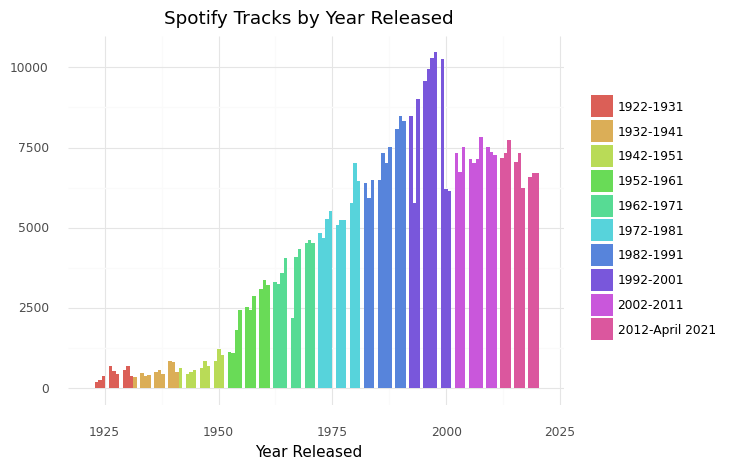

<ggplot: (109131171804)>
Here we see that the largest amount of tracks on Spotify were released after 1975.
These next bar plots show the 10 most popular genres per decade broken down by year.


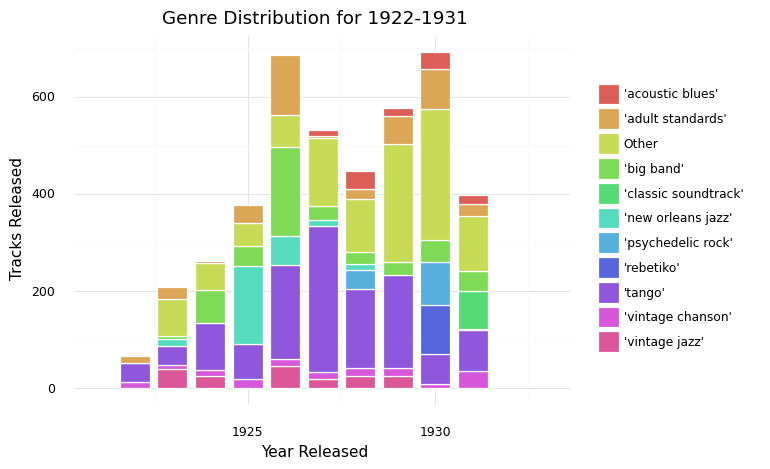

<ggplot: (109122132155)> 

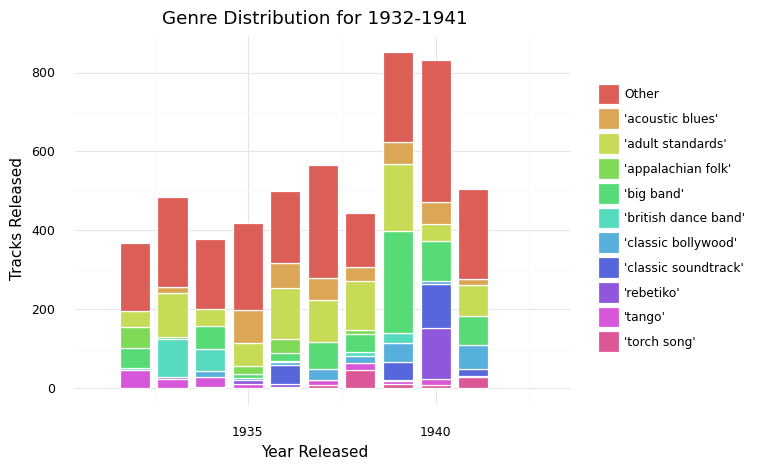

<ggplot: (109122146323)> 

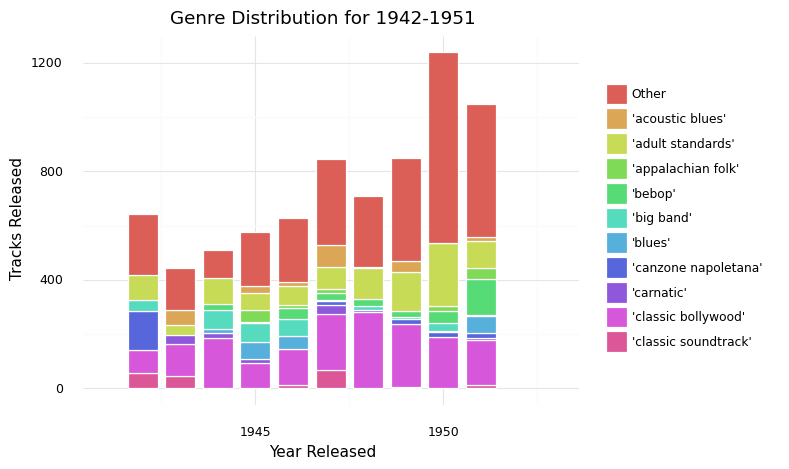

<ggplot: (109131153143)> 

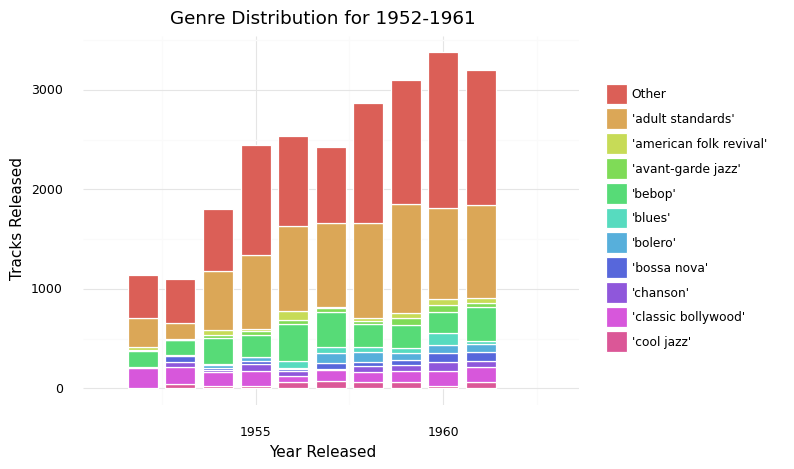

<ggplot: (109134214196)> 

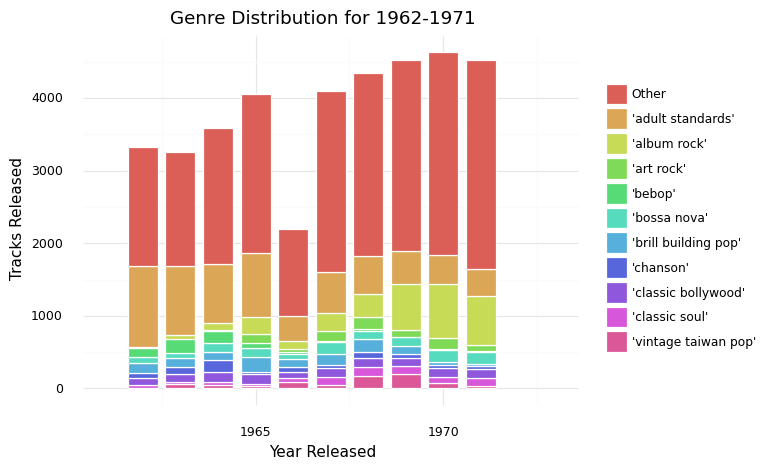

<ggplot: (109134244494)> 

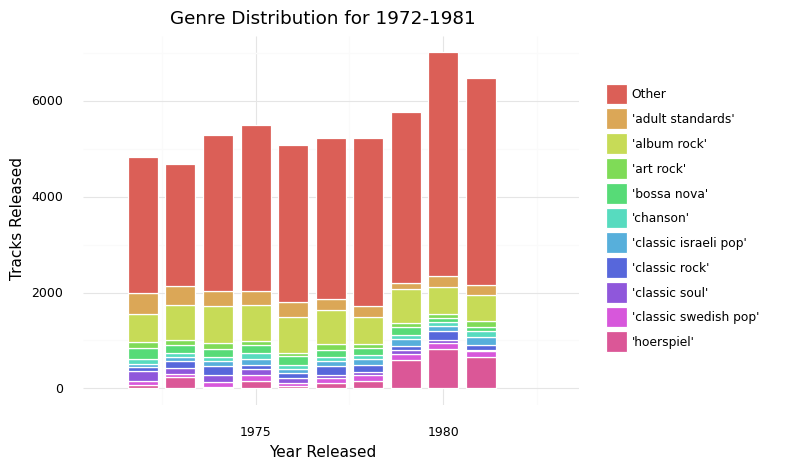

<ggplot: (109240792592)> 

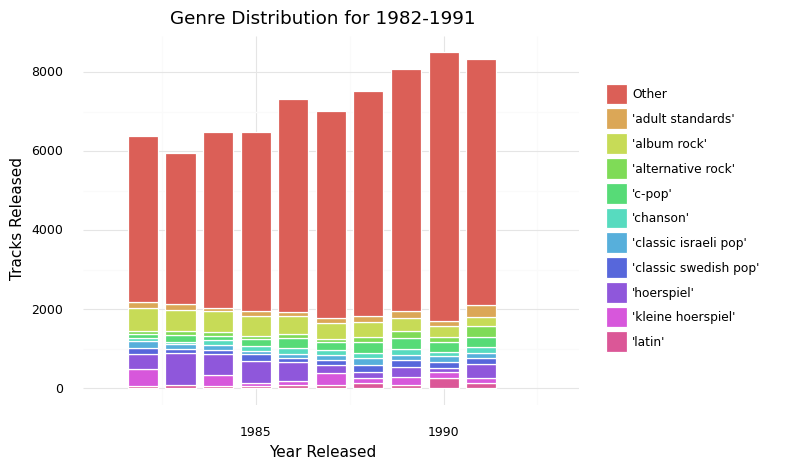

<ggplot: (109240783812)> 

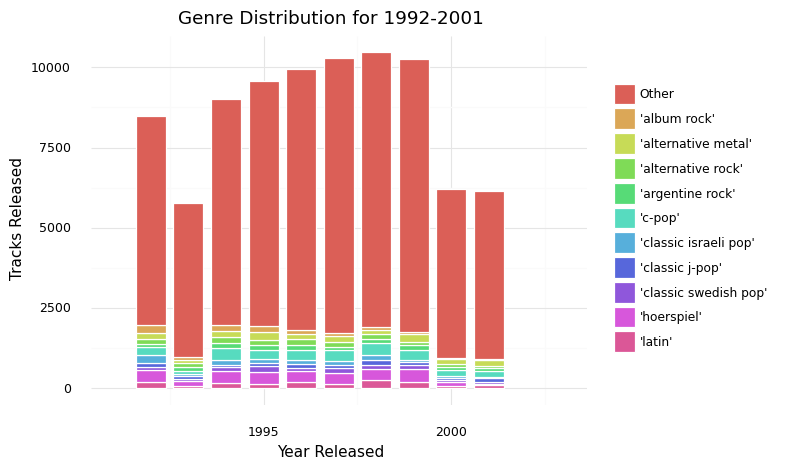

<ggplot: (109134235889)> 

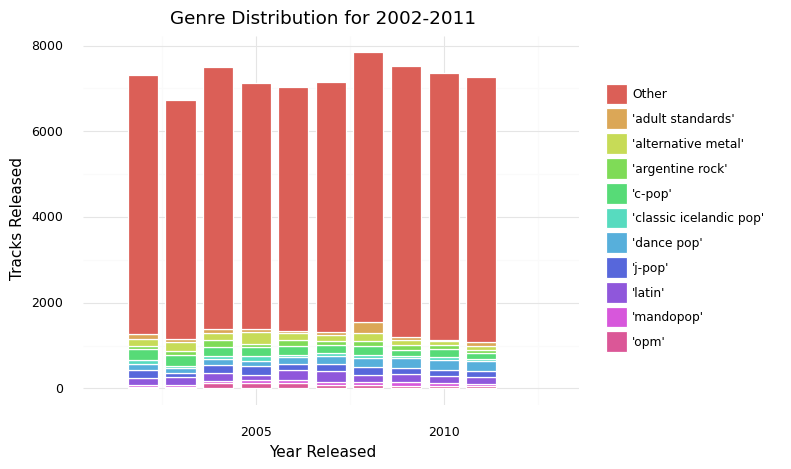

<ggplot: (109122254303)> 

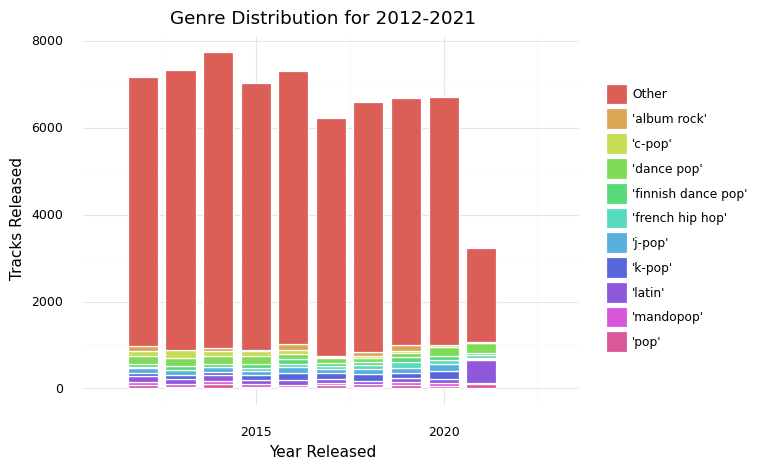

<ggplot: (109122240235)>


In [215]:
print(track_plot)
print("Here we see that the largest amount of tracks on Spotify were released after 1975.")
print("These next bar plots show the 10 most popular genres per decade broken down by year.")
print(plot22, plot32, plot42, plot52, plot62, plot72, plot82, plot92, plot02, plot12)

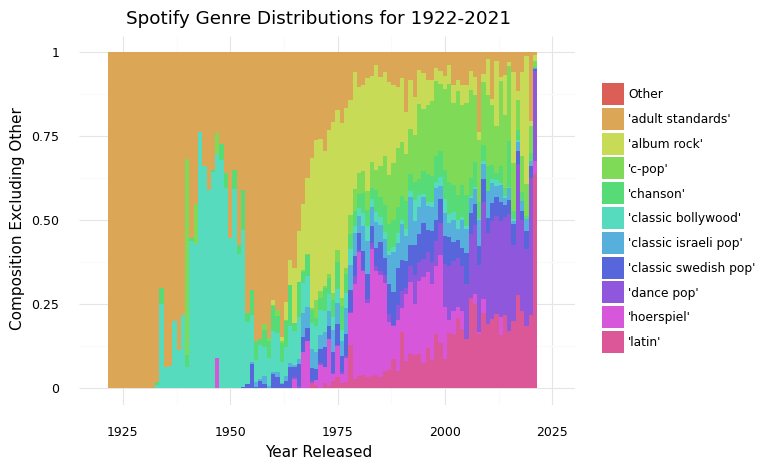

<ggplot: (109134233351)>

Here are the overall top 10 genres in Spotify's music catalog.
This visualization excludes the 'Other' category to make the trends for the top 10 genres more clear.


In [216]:
print(overall_plot)
print("\nHere are the overall top 10 genres in Spotify's music catalog.")
print("This visualization excludes the 'Other' category to make the trends for the top 10 genres more clear.")

## Question #6: 
### Do different genres see varying levels of popularity, and does this change over time?

In a word, yes! These graphs show the top 10 genres for all the songs over each decade, starting in 1922. While the listening data or Billboard 100 information is not available, especially for songs that predate that type of opinion collection, the existence of recordings implies a trend for producing and selling that music that must have been driven by some sort of customer demand. The top 10 genres with the most recordings on Spotify changes from decade to decade, implying changing tastes and the diffusion of Western recording techniques. Taking a look at the top 10 genres of all Spotify-recorded-time, we see that each one has its own heyday. Latin music increased in recording frequency from 1975 onwards, while dance pop seriously grew starting in the 2000's. Album rock was prominent in the 1970's-1990's, and remains relevant today. 
Another important consideration is the ever-growing "other" category in the decade graphs. This shows that the variety of genres has been growing throughout the 1922-2021 period, which also means that Spotify has a large collection of different music. This increase in genre diversity implies advancement in music and in whose voices are heard by recording companies.

## Question #1 and #4: By what characteristics can we group/cluster tracks? What subcategories of tracks exist?


#### Choose and standardize only numerical variables for clustering

In [217]:
features = ['duration_ms', 'danceability', 'energy', 'loudness',
'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
'artist_followers', 'artist_popularity', 'release_year', 'track_popularity']
spotify_sample = spotify.sample(frac = 0.10, random_state = 2000)

x_vars = (spotify_sample[features])

z = StandardScaler()
xz_vars = z.fit_transform(x_vars)

#### Perform hierarchical agglomerative clustering and viewing silhouette score

In [218]:
hac = AgglomerativeClustering(affinity = "euclidean",
                             linkage = "single")
hac.fit(xz_vars)
membership = hac.labels_

In [219]:
silhouette_score(xz_vars,membership)

0.8772427597240955

In [220]:
spotify_sample["clusters"] = membership

In [221]:
cluster0 = (spotify_sample['clusters'] == 0)
spotify_cluster0 = spotify_sample[cluster0]
#spotify_cluster0

In [222]:
cluster1 = (spotify_sample['clusters'] == 1)
spotify_cluster1 = spotify_sample[cluster1]
#spotify_cluster1

#### Visualize the cluster memberships and popularity of tracks in the clusters

In [223]:
cluster_member_plot = (ggplot(spotify_sample, aes(x = "factor(clusters)")) + geom_bar( fill = "teal") + 
                       theme_minimal() + ylab("Rows") +
                      ggtitle("Cluster Membership") + theme(axis_title_x = element_blank()))


In [224]:
cluster_track_pop = (ggplot(spotify_sample, aes(x = "factor(clusters)", y= "track_popularity")) + geom_boxplot( fill = 'coral') + 
                       theme_minimal() + ylab("Track Popularity by Cluster") +
                      ggtitle("Track Popularity") + theme(axis_title_x = element_blank()))

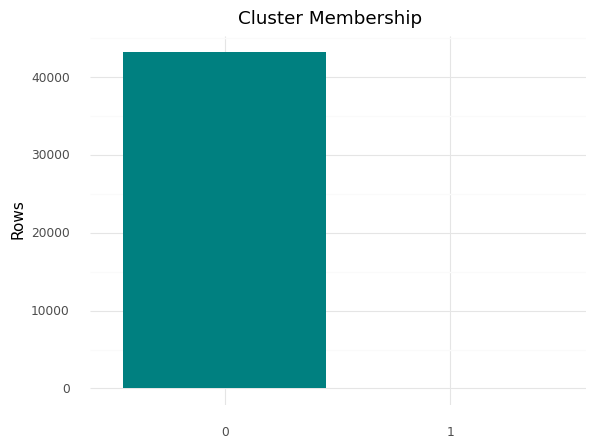

<ggplot: (109240785884)> 
We can see that the member of Cluster 1 doesn't even show up in comparison to Cluster 0.


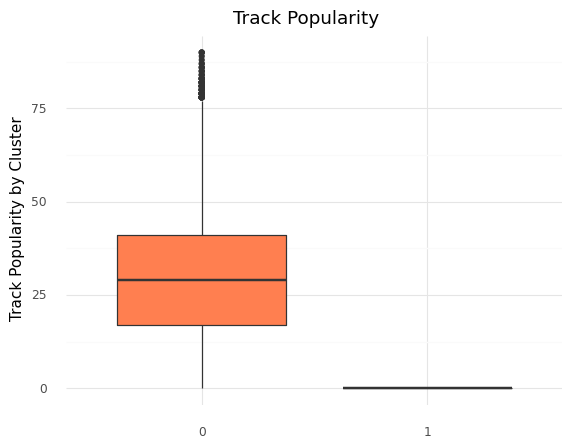

<ggplot: (109240793085)> 
For the track popularity variable, we can see the distribution of the data for this sample.
The average track popularity is around 30/100, whereas the one track in Cluster 1 is not popular at all.


In [225]:
print(cluster_member_plot, "\nWe can see that the member of Cluster 1 doesn't even show up in comparison to Cluster 0.")
print(cluster_track_pop, "\nFor the track popularity variable, we can see the distribution of the data for this sample.")
print("The average track popularity is around 30/100, whereas the one track in Cluster 1 is not popular at all.")

## Question #1 and #4: 
### By what characteristics can we group/cluster tracks? What subcategories of tracks exist?

I have used a bar chart to display visually how unbalanced the cluster membership is, instead of seeing the clusters through a dendrogram. I am using a box-and-whisker plot to see the distribution of track popularity across this sampled data.

This Hierarchichal Agglomerative Clustering algorithm did not allow us to cluster and discover subgenres of tracks in a meaningful way. It grouped the randomly sampled data into 2 clusters or groups, which initially seemed promising. This HAC model also returned a high silhouette score, which means that the clusters are separable and cohesive. The group members are close to each other and far away from the other cluster. However, all points except 1 (43,199) belong to the first cluster, Cluster 0, and the other point makes up its own cluster. This implies that the relationships between individual points and genres and subgenres is not able to be viewed through this type of clustering.

To attempt this clustering, I would test out other algorithms like K-Means, Gaussian Mixture Models, and DBSCAN.